In [1]:
%load_ext autoreload
%autoreload 2

# Introduction to Ecotracer Linear Dynamics

EwE calculates contaminant concentrations using time-stepping simulations (Ecotracer) coupled with Ecosim. However, if we assume the biomasses and diet compositions are constant (or changing slowly relative to contaminant kinetics), the contaminant transfer can be formulated as a linear system. From my limited reading of Ecotracer publications is that the underlying Ecosim is parameterised in a way to produce a stabe system, then held constant whilst ecotracer runs. 

## 1. The Mathematical Formulation

For any functional group $i$, the rate of change of contaminant concentration $C_i$ is the sum of inputs minus the sum of outputs. 

$$ \frac{dC_i}{dt} = \sum \text{Inputs} - \sum \text{Outputs} $$ 

Since uptake and loss rates in Ecotracer are linear with respect to concentration (e.g., Predation Gain depends on Prey Concentration, Metabolic Loss depends on Body Concentration), we can organize these terms into a matrix form: 

$$ \frac{d\mathbf{C}}{dt} = \mathbf{b} - \mathbf{M} \cdot \mathbf{C} $$ 

Where:
*   $\mathbf{C}$ is the vector of concentrations (Environment + $N$ groups). 
*   $\mathbf{b}$ (Intercept Vector) represents independent inflows, such as Base Inflow into the environment or Immigration of contaminated biomass. 
*   $\mathbf{M}$ (Coefficient Matrix) represents the rates of transfer between groups (Predation) and losses from the system (Decay, Metabolism). 

## 2. Analytical Equilibrium

A major advantage of this linear formulation is that we can solve for the steady-state equilibrium analytically, without using numerical methods. 

At equilibrium, the rate of change is zero: 

$$ 0 = \mathbf{b} - \mathbf{M} \cdot \mathbf{C}_{eq} $$ 

$$ \mathbf{M} \cdot \mathbf{C}_{eq} = \mathbf{b} $$ 

$$ \mathbf{C}_{eq} = \mathbf{M}^{-1} \cdot \mathbf{b} $$ 

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyewe as ewe

# Add source to path for local imports if necessary
sys.path.append("../src")

from ecotracer_analytics.core import EcopathSource, EcotracerSource
from ecotracer_analytics.linear_system import (
    calculate_coefficient, 
    calculate_intercept, 
    calculate_equilibrium
)
from ecotracer_analytics.dynamics import simulate_dynamics, build_state_vector, simulate_dynamics_with_matrices

# Plotting style
plt.style.use('seaborn-v0_8')

## 3. Loading the Model

We load the **East Bass Strait** model. We select:
*   **EcoSim Scenario:** `constant fishing` (Assuming stable biomasses). 
*   **Ecotracer Scenario:** `smaller_equi` (Baseline contaminant parameters).

In [3]:
MODEL_PATH = "East Bass Strait.eiixml"
SCENARIO_ECOSIM = "constant fishing"
SCENARIO_ECOTRACER = "smaller_equi"

print(f"Loading {MODEL_PATH}...")
model = ewe.EwEScenarioInterface(
    MODEL_PATH,
    ecosim_scenario=SCENARIO_ECOSIM,
    ecotracer_scenario=SCENARIO_ECOTRACER
)

# Run initialization to populate the core with data
model.run_scenarios(pd.DataFrame({"scenario": [1]}))
core = model._core_instance

# Wrap the core in Analytics Sources
path_source = EcopathSource(core)
tracer_source = EcotracerSource(core)
tracer_source.base_inflow = 1e-5

print("Model loaded successfully.")

Loading East Bass Strait.eiixml...


Running scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Model loaded successfully.


## 4. Calculating Baseline Equilibrium

`ecotracer-analytics` provides methods to calculate the formulation of the system as well as directly calculate the equilibrium state.

In [4]:
# Extract Linear System
M_base = calculate_coefficient(path_source, tracer_source)
b_base = calculate_intercept(path_source, tracer_source)

# Solve for Equilibrium
C_eq_base = calculate_equilibrium(path_source, tracer_source)

print(f"System Size: {M_base.shape}")
print(f"Base Inflow Rate: {tracer_source.base_inflow}")
print(f"Equilibrium Env Concentration: {C_eq_base[0]:.6f}")

System Size: (60, 60)
Base Inflow Rate: 1e-05
Equilibrium Env Concentration: 0.000054


## 5. Perturbation: Doubling the Inflow

We now simulate a scenario where the contaminant inflow into the environment doubles. 
Because our system is linear, we expect the equilibrium concentrations to respond linearly (doubling), provided no other non-linear dynamics are at play. 

We modify the `tracer_source` object directly to reflect this parameter change.

In [5]:
# Create a copy of the source to avoid modifying the original if needed, 
# but here we just modify the attribute directly for demonstration.
old_inflow = tracer_source.base_inflow
new_inflow = old_inflow * 3.0

print(f"Changing Base Inflow: {old_inflow} -> {new_inflow}")
tracer_source.base_inflow = new_inflow

# Recalculate System Matrices (M usually stays same, b changes)
M_new = calculate_coefficient(path_source, tracer_source)
b_new = calculate_intercept(path_source, tracer_source)

# Calculate New Analytical Equilibrium
C_eq_new = np.linalg.solve(M_new, b_new)

print(f"New Equilibrium Env Concentration: {C_eq_new[0]:.6f}")
print(f"Ratio (New/Old): {C_eq_new[0]/C_eq_base[0]:.2f}")

Changing Base Inflow: 1e-05 -> 3.0000000000000004e-05
New Equilibrium Env Concentration: 0.000069
Ratio (New/Old): 1.28


## 6. Simulating the Transition

Now that the system is formulated nicely, we can use existing python packages such as `scipy` to simulate the system with a range of solvers.

We simulate the system over time, starting from the **Baseline Equilibrium** ($C_{eq\_base}$) and subjecting it to the **New Parameters** (Doubled Inflow).

In [6]:
# Time span: 0 to 100 years
t_span = (0, 30)
t_eval = np.linspace(t_span[0], t_span[1], 200)

# Initial State = Old Equilibrium
y0 = C_eq_base

# Run Simulation
sol = simulate_dynamics(
    path_source, 
    tracer_source, # This source now contains the DOUBLED inflow
    y0, 
    t_span, 
    t_eval=t_eval,
    method="Radau"
)

# Extract results
time = sol.t
concentrations = sol.y.T # Shape: (Time, Groups)

## 7. Visualization

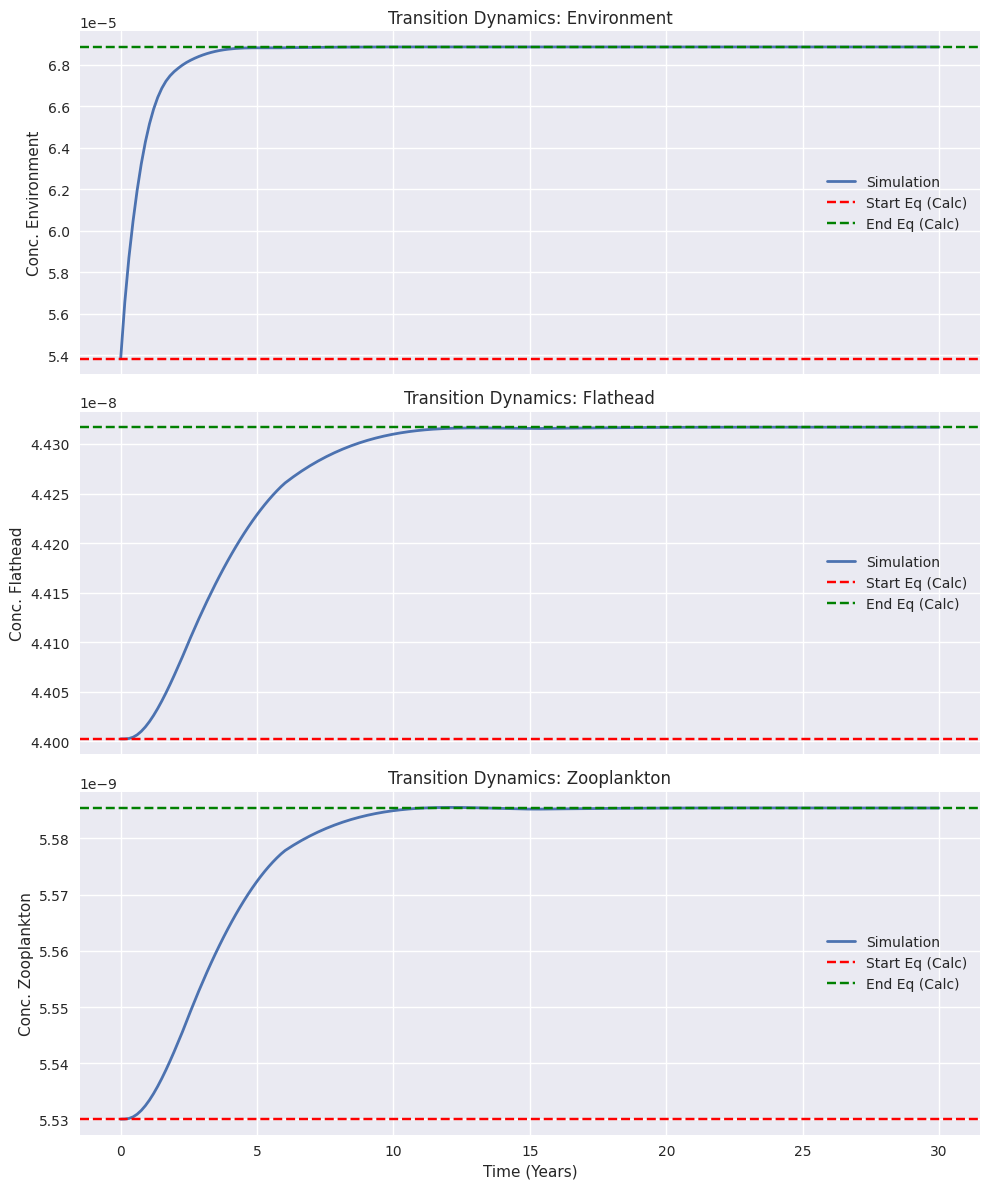

In [7]:
groups_to_plot = [
    (0, "Environment"),
    (5, "Flathead"), # Example Predator
    (20, "Zooplankton") # Example Prey
]

fig, axes = plt.subplots(len(groups_to_plot), 1, figsize=(10, 12), sharex=True)

for ax, (idx, name) in zip(axes, groups_to_plot):
    # Plot Simulation
    ax.plot(time, concentrations[:, idx], label='Simulation', linewidth=2)
    
    # Plot Equilibriums
    ax.axhline(C_eq_base[idx], color='red', linestyle='--', label='Start Eq (Calc)')
    ax.axhline(C_eq_new[idx], color='green', linestyle='--', label='End Eq (Calc)')
    
    ax.set_ylabel(f"Conc. {name}")
    ax.legend()
    ax.set_title(f"Transition Dynamics: {name}")

axes[-1].set_xlabel("Time (Years)")
plt.tight_layout()
plt.show()

## 8. Non-Environmental Forcing Hypothetical Scenario

Suppose now we a have an extrememly localised contaminent release that is large and persistent. Consider the following assumptions

* The environmental contaminant concentration is 100 times greater locally around the source release

$$ C_{e, l} = 100 \cdot C_{env}$$

* 1% of biomass from primary producers and benthic producers reside within the point release.

$$B_{p, l} = 0.005 \cdot B_{p}$$

* The point source release increase mercury inflow by 1%

$$C_{inflow}' = C_{inflow} \cdot 1.001 $$

Then there is an forcing inflow into primary producer group of the following

$$ C_{forcing} = u \cdot 0.005 \cdot B_{p} \cdot 100 \cdot C_{e}$$

In [13]:
# Re-initialise source params
path_source = EcopathSource(core)
tracer_source = EcotracerSource(core)
tracer_source.base_inflow = 1e-5

# Extract Linear System
M_base = calculate_coefficient(path_source, tracer_source)
b_base = calculate_intercept(path_source, tracer_source)

# Solve for Equilibrium
C_eq_base = calculate_equilibrium(path_source, tracer_source)

grp_idxs = np.array(core.get_functional_group_indices(["Primary producers", "Benthic producer"])) - 1
inflow_forcing = tracer_source.dir_abs_r[grp_idxs] * 0.01 * path_source.biomass[grp_idxs] * 100 * C_eq_base[0]

**We can inject forcing scenarios into the intercept vector of the linear system.**

In [14]:
b_base[grp_idxs + 1] = inflow_forcing
b_base[0] *= 1.001

In [15]:
# Calculate New Analytical Equilibrium
C_eq_new = np.linalg.solve(M_base, b_base)

print(f"New Equilibrium Env Concentration: {C_eq_new[0]:.6f}")
print(f"Ratio (New/Old): {C_eq_new[0]/C_eq_base[0]:.2f}")

New Equilibrium Env Concentration: 0.000056
Ratio (New/Old): 1.03


In [16]:
# Time span: 0 to 100 years
t_span = (0, 30)
t_eval = np.linspace(t_span[0], t_span[1], 200)

# Initial State = Old Equilibrium
y0 = C_eq_base

# Run Simulation
sol = simulate_dynamics_with_matrices(
    M_base, 
    b_base, # This source now contains the DOUBLED inflow
    y0, 
    t_span, 
    t_eval=t_eval,
    method="Radau"
)

# Extract results
time = sol.t
concentrations = sol.y.T # Shape: (Time, Groups)

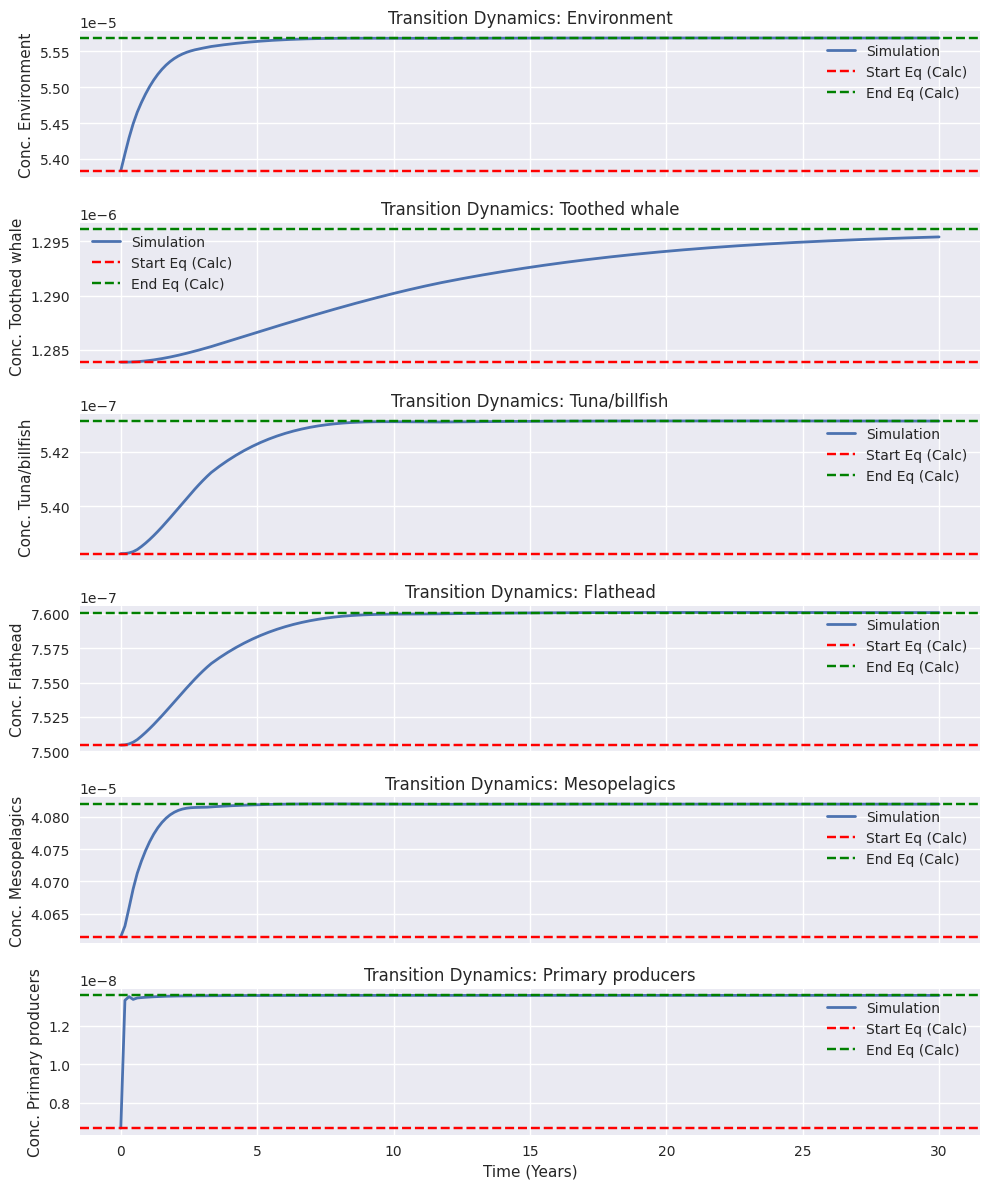

In [17]:
fg_names = ["Toothed whale", "Tuna/billfish", "Flathead", "Mesopelagics", "Primary producers"]
idxs = core.get_functional_group_indices(fg_names)
groups_to_plot = [(0, "Environment"), *zip(idxs, fg_names)]

fig, axes = plt.subplots(len(groups_to_plot), 1, figsize=(10, 12), sharex=True)

for ax, (idx, name) in zip(axes, groups_to_plot):
    # Plot Simulation
    ax.plot(time, concentrations[:, idx], label='Simulation', linewidth=2)
    
    # Plot Equilibriums
    ax.axhline(C_eq_base[idx], color='red', linestyle='--', label='Start Eq (Calc)')
    ax.axhline(C_eq_new[idx], color='green', linestyle='--', label='End Eq (Calc)')
    
    ax.set_ylabel(f"Conc. {name}")
    ax.legend()
    ax.set_title(f"Transition Dynamics: {name}")

axes[-1].set_xlabel("Time (Years)")
plt.tight_layout()
plt.show()